<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Helium_Mobius_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ζ=1.200  E_num=-2.518753 a.u.
ζ=1.300  E_num=-2.521221 a.u.
ζ=1.400  E_num=-2.508305 a.u.
ζ=1.500  E_num=-2.480059 a.u.
ζ=1.600  E_num=-2.436525 a.u.
ζ=1.700  E_num=-2.377741 a.u.
ζ=1.800  E_num=-2.303736 a.u.
ζ=1.900  E_num=-2.214534 a.u.
ζ=2.000  E_num=-2.110157 a.u.
ζ=2.100  E_num=-1.990621 a.u.
ζ=2.200  E_num=-1.855939 a.u.


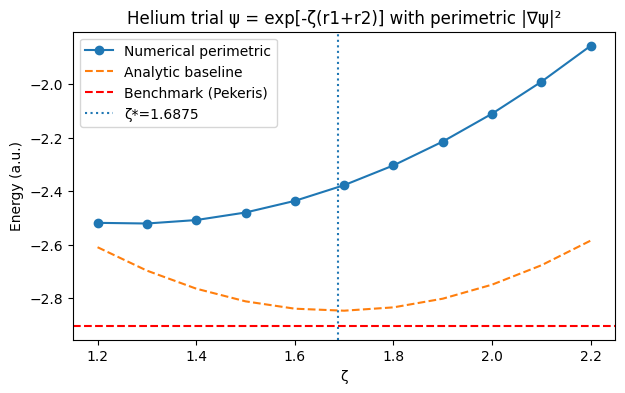


Numerical minimum: E ≈ -2.521221 a.u. at ζ ≈ 1.300
Analytic optimum : E ≈ -2.847656 a.u. at ζ=1.6875


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.laguerre import laggauss

Z = 2.0  # Helium nuclear charge

# ===============================
# 1. Perimetric coordinates
# ===============================
# u,v,w >= 0
# r1=(v+w)/2, r2=(u+w)/2, r12=(u+v)/2
def r_vars(u,v,w):
    r1 = 0.5*(v+w)
    r2 = 0.5*(u+w)
    r12= 0.5*(u+v)
    return r1,r2,r12

# Correct Jacobian (after angular integration)
def J_per(u,v,w):
    return 0.125 * u*v*w*(u+v)*(v+w)*(w+u)

# Trial wavefunction
def psi(r1,r2,zeta):
    return np.exp(-zeta*(r1+r2))

# ===============================
# 2. Numerical derivatives
# ===============================
def grad_sq(u,v,w,zeta,eps=1e-4):
    """Compute |∇ψ|^2 numerically in (u,v,w) by finite differences"""
    r1,r2,r12 = r_vars(u,v,w)
    base = psi(r1,r2,zeta)
    # finite differences wrt u,v,w
    dpsi = []
    for shift in [(eps,0,0),(0,eps,0),(0,0,eps)]:
        du,dv,dw = shift
        r1p,r2p,r12p = r_vars(u+du,v+dv,w+dw)
        r1m,r2m,r12m = r_vars(u-du,v-dv,w-dw)
        psip = psi(r1p,r2p,zeta)
        psim = psi(r1m,r2m,zeta)
        deriv = (psip-psim)/(2*eps)
        dpsi.append(deriv)
    # |∇ψ|^2 in perimetric coords (approximate)
    return dpsi[0]**2 + dpsi[1]**2 + dpsi[2]**2

# ===============================
# 3. Integration by Gauss–Laguerre
# ===============================
def gauss_laguerre(n,scale=1.0):
    x,w = laggauss(n)
    return x/scale, w/scale

def EV_perimetric(zeta, n=30):
    u,wu = gauss_laguerre(n,1.0)
    v,wv = gauss_laguerre(n,1.0)
    w,ww = gauss_laguerre(n,1.0)
    S=0.0; V=0.0; T=0.0
    for a,ua in enumerate(u):
        for b,vb in enumerate(v):
            for c,wc in enumerate(w):
                r1,r2,r12 = r_vars(ua,vb,wc)
                J = J_per(ua,vb,wc)
                wt = wu[a]*wv[b]*ww[c]*J
                val = psi(r1,r2,zeta)
                psi2 = val*val
                # Overlap
                S += wt*psi2
                # Potential
                Vloc = -Z/(r1+1e-14) - Z/(r2+1e-14) + 1.0/(r12+1e-14)
                V += wt*psi2*Vloc
                # Kinetic via |∇ψ|^2
                Tloc = 0.5*grad_sq(ua,vb,wc,zeta)
                T += wt*Tloc
    return (T+V)/S

# ===============================
# 4. Scan over ζ
# ===============================
zlist = np.linspace(1.2,2.2,11)
Evals = []
for z in zlist:
    E = EV_perimetric(z,n=25)
    Evals.append(E)
    print(f"ζ={z:.3f}  E_num={E:.6f} a.u.")

z_opt = zlist[np.argmin(Evals)]
E_opt = np.min(Evals)

# Analytic baseline (uncorrelated exponential)
def E_analytic(z): return z*z - (27.0/8.0)*z
Ea = [E_analytic(z) for z in zlist]

plt.figure(figsize=(7,4))
plt.plot(zlist,Evals,"-o",label="Numerical perimetric")
plt.plot(zlist,Ea,"--",label="Analytic baseline")
plt.axhline(-2.903724,ls="--",c="r",label="Benchmark (Pekeris)")
plt.axvline(27/16,ls=":",label="ζ*=1.6875")
plt.xlabel("ζ"); plt.ylabel("Energy (a.u.)")
plt.title("Helium trial ψ = exp[-ζ(r1+r2)] with perimetric |∇ψ|²")
plt.legend(); plt.show()

print(f"\nNumerical minimum: E ≈ {E_opt:.6f} a.u. at ζ ≈ {z_opt:.3f}")
print(f"Analytic optimum : E ≈ {-2.847656:.6f} a.u. at ζ=1.6875")
